In [7]:
import os
import sys
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn import decomposition
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize

lambert_crs = ccrs.LambertConformal(
    central_longitude=-107.0,
    central_latitude=50.0,
    standard_parallels=[50.0, 50.0],
    false_easting=5632642.22547,
    false_northing=4612545.65137
)

In [2]:
main = gpd.read_file('~/Desktop/columbia/capstone/weatherregimes/full_globfire/full_globfire.shp')
main = pd.concat([main,main.bounds], axis=1)

In [8]:
data = pd.read_csv('../data/merged_output.csv').drop(['time','id1','id2'],axis=1)
data['_uid_'] = data['source_file'].str.extract(r'_(\d+\.?\d*)_')
df_pivoted = data.drop(columns=['source_file']).set_index(['_uid_', 'y', 'x', 'level']).unstack('level')

df_pivoted.columns = [f'{level}-{var}' for var, level in df_pivoted.columns]
df = df_pivoted.reset_index().drop(columns=['y','x','_uid_'])

X = df[~np.isnan(df).any(axis=1)]
X = normalize(X,axis=0)

In [45]:
df_pivoted.index.get_level_values('_uid_').unique()

Index(['10.0', '1001648.0', '1001649.0', '1001665.0', '1001671.0', '1001674.0',
       '1001675.0', '1001679.0', '1001680.0', '1001681.0', '1001682.0',
       '1001683.0', '1001684.0', '1002110.0', '1002112.0'],
      dtype='object', name='_uid_')

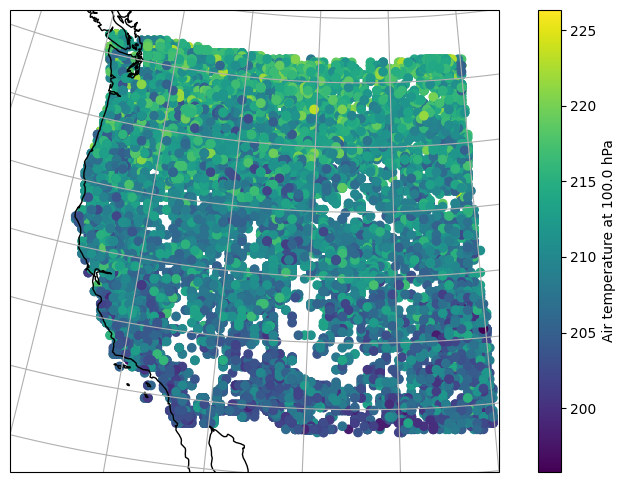

In [60]:
plot_data = df_pivoted.reset_index().groupby('_uid_', as_index=False).mean()
x_coords = plot_data['x'].values
y_coords = plot_data['y'].values
values = plot_data['100.0-air'].values

fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': lambert_crs})
scatter = ax.scatter(x_coords, y_coords, c=values, cmap='viridis', transform=None)
plt.colorbar(scatter, ax=ax, orientation='vertical', label='Air temperature at 100.0 hPa')

ax.set_extent([235, 260, 30, 50],crs=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=False)

plt.show()

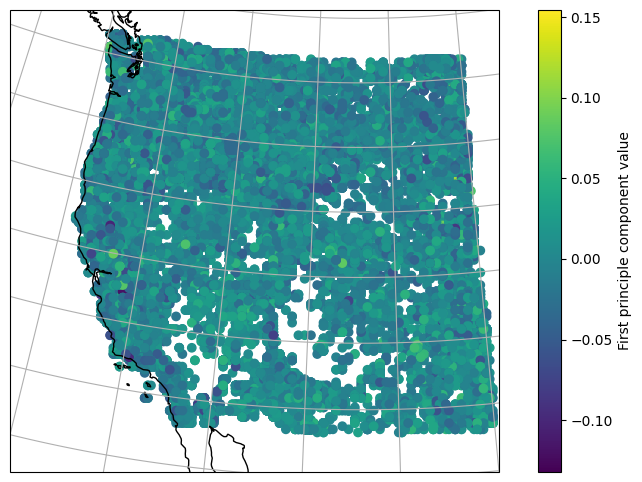

In [68]:
X = plot_data.drop(columns=['_uid_','y','x'])
X = X[~np.isnan(X).any(axis=1)]
X = normalize(X,axis=0)

pca = decomposition.PCA(n_components=1)
pca.fit(X)
plot_data['pc1'] = pca.transform(X)

x_coords = plot_data['x'].values
y_coords = plot_data['y'].values
values = plot_data['pc1'].values

fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': lambert_crs})
scatter = ax.scatter(x_coords, y_coords, c=values, cmap='viridis', transform=None)
plt.colorbar(scatter, ax=ax, orientation='vertical', label='First principle component value')

ax.set_extent([235, 260, 30, 50],crs=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=False)

In [19]:
from sklearn.metrics import davies_bouldin_score

In [17]:
df = df_pivoted.reset_index().groupby('_uid_', as_index=False).mean().drop(columns=['y','x','_uid_'])
X = df[~np.isnan(df).any(axis=1)]
X = normalize(X,axis=0)

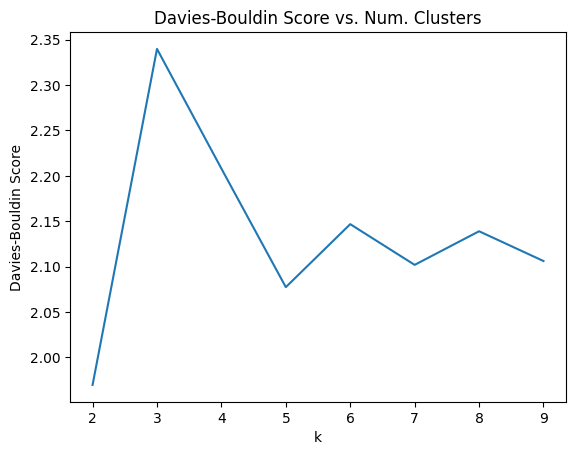

In [30]:
values = []
k_values = np.arange(2, 10)
for k in np.arange(2,10):
    kmeans = KMeans(n_clusters=k)
    kmeans_labels = kmeans.fit_predict(X)

    db_score = davies_bouldin_score(X, kmeans_labels)
    values.append(db_score)

plt.plot(k_values, values)
plt.xlabel("k")
plt.ylabel("Davies-Bouldin Score")
plt.title("Davies-Bouldin Score vs. Num. Clusters")
plt.show()